<a href="https://colab.research.google.com/github/ZeroLeon/Chinese_htlData_Classification_with_BERT/blob/master/Chinese_htlData_Classification_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#在Fastai框架下基于BERT模型的中文文本分类


##Preparation

In [0]:
#安装pytorch下包含BERT预训练模型的库
!pip install pytorch-pretrained-bert

In [0]:
#引入必要的依赖包
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [0]:
#设置一个config类，便于参数配置与更改
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-chinese", 
    #选用中文预训练模型：Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters
    max_lr=3e-5,
    epochs=1,
    use_fp16=False, #fastai里可以方便地调整精度，加快训练速度：learner.to_fp16()
    bs=8,
    max_seq_len=128, #选取合适的seq_length，较大的值可能导致训练极慢报错等
)

##Customize Tokenizer and Vocab

In [8]:
#pytorch_bert包提供了BertTokenizer类，从选取的模型中提取tok
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

100%|██████████| 109540/109540 [00:00<00:00, 4157187.61B/s]


定制Tokenizer需要继承fastai的BaseTokenizer类，注意BERT会在sequence的首尾加上特殊token[CLS]和[SEP]，与fastai里的bos和eos有重合，所以在之后会有include_eos=Fasle的设置

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around a BertTokenizer to be a BaseTokenizer in fastai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
#最终的tokenizer
fastai_tokenizer = Tokenizer(
    tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), 
    pre_rules=[], 
    post_rules=[]
)

In [11]:
#check the vocab
list(bert_tok.vocab.items())[1090:1110]

[('冗', 1090),
 ('写', 1091),
 ('军', 1092),
 ('农', 1093),
 ('冠', 1094),
 ('冢', 1095),
 ('冤', 1096),
 ('冥', 1097),
 ('冨', 1098),
 ('冪', 1099),
 ('冬', 1100),
 ('冯', 1101),
 ('冰', 1102),
 ('冲', 1103),
 ('决', 1104),
 ('况', 1105),
 ('冶', 1106),
 ('冷', 1107),
 ('冻', 1108),
 ('冼', 1109)]

In [0]:
#设置vocab
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

##Dataset

本次使用的数据集信息：

*   名称及出处：[ChnSentiCorp_htl_all](https://github.com/ZeroLeon/ChineseNlpCorpus/blob/master/datasets/ChnSentiCorp_htl_all/intro.ipynb)
*   数据概览： 7000 多条酒店评论数据，5000 多条正向评论，2000 多条负向评论
*   推荐实验： 情感/观点/评论 倾向性分析
*   数据来源： 携程网
*   原数据集： ChnSentiCorp_htl，由谭松波老师整理的一份数据集



In [0]:
#在colab下接入google drive，方便保存模型修改文件，使用其他kernel可跳过这一步
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)
base_dir = '/content/gdrive/My Drive/fastai'
path = Path(base_dir +'/data/htl_reviews')
# path.mkdir(parents=True,exist_ok=True)
os.chdir(path)

In [0]:
!wget https://github.com/SophonPlus/ChineseNlpCorpus/raw/master/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv

In [0]:
df_htl = pd.read_csv('ChnSentiCorp_htl_fix.csv',index_col=0)

In [39]:
#标签涵义：1代表正向评论，0代表负向评论
label_denotation = {1:'positive',0:'negative'}
df_htl.sample(10)

,label,review
803,1,房间能观景，很好~~主要是很方便。出门就是太平洋广场，很繁华的地段
3675,1,酒店房间好，阳光明媚，卫生间大，可惜没享受。司机说，到拉萨第一天不要洗澡。房间空调足。好像早...
3539,1,房间很新，服务员水平也很高，物有所值。4楼房间太压抑，这次先进了4楼然后不满意很快换到10楼...
6772,0,"酒店实在太差了,房间隔音极差,北塔挨着迪吧，快曲放到半夜3点；换到南塔，又挨着KTV音乐响到..."
2431,1,交通方便，对面就是国美电器。出入的车辆比较多，又刚好处于路口，所以有点混乱。5楼可以喝晚茶，...
6511,0,Thepositionofthishotelisverybad.补充点评2008年4月6日：...
3634,1,酒店自动把房间升级成套房，不错，赞一下！但服务人员未免太自说自话，送水果也不能未经同意就自己...
5374,0,我感觉不行。。。性价比很差。不知道是银川都这样还是怎么的！
1926,1,角房太冷了，tnnd。角房太冷了，tnnd。角房太冷了，tnnd。
7087,0,设施非常旧，周边环境也不好，最奇怪是房间内没有暖气，只有挂壁空调，要知道，这种空调室外-5度...


In [0]:
#分割训练集train与验证集val
from sklearn.model_selection import train_test_split

train, val = train_test_split(df_htl)

In [41]:
#check their size
print(train.shape,val.shape)

(5823, 2) (1942, 2)


In [0]:
#建立TextDataBunch
databunch = TextClasDataBunch.from_df(".", train, val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="review",
                  label_cols='label',
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [43]:
databunch.show_batch()

text,target
[CLS] 51 还 是 选 择 了 这 里 ， 因 为 贵 的 太 贵 ， 好 的 都 定 满 了 。 在 51 小 黄 金 288 元 的 价 格 是 属 于 便 宜 的 ， 之 前 打 电 话 去 游 记 中 有 人 写 到 的 枫 枫 旅 行 社 ， 一 个 私 人 开 的 小 旅 馆,1
[CLS] 洲 际 酒 店 ， 携 程 的 价 格 确 实 有 竞 争 力 。 应 该 是 沈 阳 最 便 宜 的 五 星 级 酒 店 。 1 ） 地 理 位 置 ： 位 于 商 业 街 太 原 街 附 近 ， 交 通 方 便 ， 但 门 口 老 是 堵 车 ， 建 议 打 车 的 话,1
[CLS] 这 次 到 莫 干 山 自 驾 游 ， 住 在 德 清 县 的 这 个 酒 店 里 。 先 说 说 好 的 方 面 ， 酒 店 的 地 理 位 置 不 错 ， 紧 邻 免 费 开 放 的 春 晖 公 园 。 开 车 到 莫 干 山 有 两 条 路 ， 大 约 40 分 钟 。,1
[CLS] 一 般 。 除 了 便 宜 。 一 个 大 问 题 就 是 浴 缸 的 设 计 有 问 题 ， 洗 澡 的 时 候 溅 出 的 水 会 顺 着 浴 缸 靠 墙 那 边 的 平 面 一 直 流 到 外 面 的 地 上 。 等 洗 完 之 后 ， 浴 室 里 已 经 是 水 漫,0
[CLS] 凌 晨 近 二 点 到 店 ， 就 我 一 个 客 人 在 前 台 办 手 续 ， 办 了 十 分 钟 才 办 好 ， 更 郁 闷 的 是 酒 店 竟 然 开 了 一 个 没 有 打 扫 过 的 房 间 给 我 ， 房 号 46 ##3 ， 住 了 这 么 多 年 的 酒 店 还,0


##Model and Loss Function

In [44]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2)

100%|██████████| 382072689/382072689 [00:07<00:00, 48731570.08B/s]


In [0]:
#二分类问题选用CrossEntrypyLoss作为损失函数
loss_func = nn.CrossEntropyLoss()

In [0]:
#建立Learner(数据,预训练模型,损失函数)
learner = Learner(databunch, bert_model,loss_func=loss_func,metrics=accuracy)

In [47]:
#尝试寻找合适的最大学习率，这里使用了BERT原论文推荐的学习率3e-5作为默认值
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


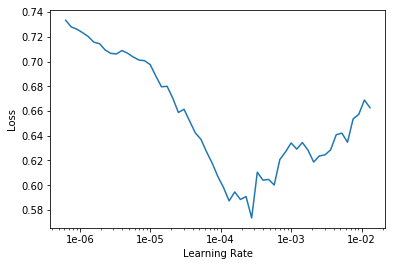

In [49]:
learner.recorder.plot(skip_end=20)

In [50]:
#开始训练
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.271018,0.230581,0.902163,04:43


In [0]:
learner.save(path/'htl_stage1')

In [53]:
#用样例测试下
learner.predict("设施老化，紧靠马路噪音太大，晚上楼上卫生间的水流声和空调噪音非常大，无法入眠")

(Category 0, tensor(0), tensor([0.9943, 0.0057]))

##What's Next?

本次task属于二元文本分类，数据集并不大，同时有相当一部分数据属于正负向情感混合的文本，容易拉低准确度，因此结果表现没那么抢眼，只能略窥BERT的强大。下一步计划使用更大的数据集做中文文本多标签分类，输出模型制作成一个能自动给文本打上情感标签的应用。